<a href="https://colab.research.google.com/github/vbejaranos/Data-Science_Habi/blob/main/Habi_Concurso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EL ALGORITMO ES CORRECTO**

*Objetivo*:

Teniendo como insumo las bases de datos entregadas por la empresa Habi, se quiere construir, modelar y predecir el precio de oferta (asking price) que Habi debe dar al inmueble que desea adquirir.

***Integrantes***

*Estadísticas Universidad Nacional de Colombia*
- Sara Lucia Acosta, slacostap@unal.edu.co
- Valeria Bejarano Salcedo, vbejaranos@unal.edu.co
- Laura Camila Cruz, laccruzpa@unal.edu.co

## Modulos y librerias




In [ ]:
#!pip install geopandas
#!pip install pyshp

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
# Trabajo con tablas y arreglos ==================================================================================#
import pandas as pd
import numpy as np
from math import sqrt
# Librerias para graficos ========================================================================================#
import matplotlib as plt
from matplotlib.pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from scipy import stats
def _color_red_or_green(val):
    color = 'red' if np.abs(val) < 0.4 else 'green'
    return 'color: %s' % color
# Librerias para georeferencia ===================================================================================#
#https://geopandas.org/docs/user_guide/set_operations.html
#from shapely.geometry import Polygon
#import shapefile
#import fiona
# Librerias para el modelamiento =================================================================================#
#DNN
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import torch
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
import sklearn as skl
from sklearn.impute import KNNImputer # Imputacion knn
# Librerías para validación de modelos ===========================================================================#
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
def starMV(x): return 0.0001 if x<1 else x
from sklearn.model_selection import cross_val_score

In [2]:
%tensorflow_version 2.x   # Para garantizar que la versión 2.x sea importada
import tensorflow as tf
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('GPU encontrada: {}'.format(nombre_gpu))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x   # Para garantizar que la versión 2.x sea importada`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
GPU encontrada: /device:GPU:0


## Conexión Google Drive con Colab 

Para una mejor gestión de los datos. Al correr el código es necesario entrar al link, dar los permisos que solicitan, copiar el código, pegar en la celda vacía y dar enter. Así solo es necesario compartir una carpeta de datos (shp)

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Completar la base de datos

Sabemos que uno de los mejores insumos para el modelamiento son los datos de buena calidad, luego bajo la filosofia de *garbage in, garbage out* se realiza una recopilación y procesamiento de la información de otras [fuentes](https://mapas.bogota.gov.co/) que nos brindan otro tipo de información necesaria dentro de este negocio inmobiliario.

## Datos de catastro

Se obtuvo la base de datos correspondiente al [avaluo](https://mapas.bogota.gov.co/?l=10462&e=-74.15372037610308,4.633364461430024,-74.0713229151657,4.674812311999409,4686&b=7256#) de la base catastral de Bogotá, con ello se cruzan por medio de la libreria geopandas con la latitud y longitud de cada inmueble dadas por Habi.

In [ ]:
#import geopandas
#data = pd.read_csv('/content/gdrive/MyDrive/shp/train_data.csv')
#points = data[['id','latitud', 'longitud']]
#catastro = geopandas.read_file('/content/gdrive/MyDrive/shp/Valor_Ref_M.shp')

In [ ]:
#catastro[['id2']]= catastro.index
#gdf = geopandas.GeoDataFrame({ 'geometry':geopandas.points_from_xy(points.longitud, points.latitud), 
#                             'id': points.id})
#catastro['ANO2'] = [i[0:4] for i in catastro.ANO]
#catastro2 = catastro[catastro.ANO2 == '2020']
#poly = geopandas.GeoDataFrame({'geometry':catastro2['geometry'],
#                              'id2': catastro2.id2 })

In [ ]:
#res_intersection = geopandas.overlay(gdf, poly, how='intersection')
#res_intersection2 = res_intersection[['id', 'id2']]
#join = res_intersection2.merge(catastro2, on='id2', how='left')
#exportar = data.merge(join, on ='id', how= 'left')
#exportar.to_csv('/content/gdrive/MyDrive/shp/train_dataV02.csv')

### Bases de datos completada por valor catastral
Una vez se realiza la intersección con los multipoligonos dados por catastro se obtienen las bases V02, a continuación se realizan la imputación de valores faltantes.

In [ ]:
data_train = pd.read_csv('/content/gdrive/MyDrive/shp/train_dataV02.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/shp/test_dataV02.csv')
data_train[['tipo_data']]= "train"
data_test[['tipo_data']] = "test"
data_train = data_train.drop(['Unnamed: 0'],axis = 1)
data_test = data_test.drop(['Unnamed: 0'],axis = 1)
consol = data_train.append(data_test)

In [ ]:
consol.columns

## Imputación de datos



Se completan los valores faltantes mediante los siguientes criterios:
1. Las siguientes variables que tienen valores faltantes se completan con 0, pues usualmente son los que el propietario tiene más en cuenta y si no se encuentran en la base, lo más seguro es que no se encuentren en el inmueble.
- Baño de servicio
- Ascensor
- Balcon
- Cuarto de servicio
- Gimnasio
- Piscina 
- Terraza 
- Remodelado
2. Para las siguientes variables se usa imputación de datos via knn (k-nearest-neighbors) para k = 5, mediante las variables de latitud y longitud, es decir, solo por localización del inmueble, pues es bastante usual que las construcciones aledañas contengan la misma arquitectura como decía Juan Sebastian en la conferencia *Uso de la ciencia de datos en la resolución de problemas del sector real*.
- Area
- Baños 
- Estrato 
- Garajes 
- Habitaciones 
- Piso 
- Salon comunal 
- Vigilancia 
- Parqueadero visitantes
- Valor administracion
- V_REF
3. Otras variables dummys, se condicionaron sobre el tipo de inmueble o conjunto para completar 0 o 1 o bien utilizar knn. Esto ya que variables como el pertenecer a un conjunto cerrado o ser un apartamento limita la aparición de estas variables.
- Deposito: apto = 0, casa = 1
- Estudio: apto = 0, casa = 1
- Porteria: conjunto cerrado = 1, no cerrado = 0
- Zona lavanderia: casas = 1,apto = knn
- Hall de alcobas: habitaciones>1 = knn,habitaciones<=1 = 0

### Completar faltantes

In [ ]:
consol[['banoservicio', 'ascensor', 'balcon', 'cuartoservicio', 'gimnasio', 'piscina', 'terraza', 'remodelado']] = consol[['banoservicio', 'ascensor', 'balcon', 'cuartoservicio', 'gimnasio', 'piscina', 'terraza', 'remodelado']].fillna(0)

In [ ]:
consol['tiponegocio'] = consol['tiponegocio'].str.lower()

In [ ]:
consol['tiempodeconstruido'] = consol['tiempodeconstruido'].replace('ntre 0 y 5 años', 'Entre 0 y 5 años')
consol['tiempodeconstruido'].unique()

In [ ]:
apto = consol[consol.tipoinmueble=='Apartamento']
casa = consol[consol.tipoinmueble=='Casa']

In [ ]:
apto[['deposito', 'estudio']] = apto[['deposito', 'estudio']].fillna(0)
casa[['deposito', 'estudio']]= casa[['deposito', 'estudio']].fillna(1)
casa[['zonalavanderia']]= casa[['zonalavanderia']].fillna(1)

In [ ]:
consol = apto.append(casa)

In [ ]:
cerrado = consol[consol.conjuntocerrado==1]
no_cerrado = consol[consol.conjuntocerrado==0]

In [ ]:
cerrado['porteria'] = cerrado['porteria'].fillna(1)
no_cerrado['porteria'] = no_cerrado['porteria'].fillna(0)
cerrado['saloncomunal'] = cerrado['saloncomunal'].fillna(1)

In [ ]:
consol= cerrado.append(no_cerrado)

In [ ]:
consol.loc[consol['valoradministracion']<10000, 'valoradministracion'] = float("NaN")

In [ ]:
train = consol[consol.tipo_data=="train"]
test = consol[consol.tipo_data=="test"]

In [ ]:
train.to_csv('/content/gdrive/MyDrive/shp/train_dataV03.csv')
test.to_csv('/content/gdrive/MyDrive/shp/test_dataV03.csv')

### Imputación via knn

Podemos ver la implementación de la metodología [aquí](https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e)

In [ ]:
data_train = pd.read_csv('/content/gdrive/MyDrive/shp/train_dataV03.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/shp/test_dataV03.csv')
data_train = data_train.drop(['Unnamed: 0'],axis = 1)
data_test = data_test.drop(['Unnamed: 0'],axis = 1)


In [ ]:
imputer = KNNImputer(n_neighbors = 5)

In [ ]:
consol1 = data_train.append(data_test)          
consol1.isna().sum()

In [ ]:
area = consol1.loc[:,['area','longitud','latitud']].values
df_area = pd.DataFrame(imputer.fit_transform(area),columns = [[ 'area','longitud','latitud']])

In [ ]:
banos = consol1.loc[:,['banos','longitud','latitud']].values
df_banos = pd.DataFrame(imputer.fit_transform(banos),columns = [[ 'banos','longitud','latitud']])
df_banos.loc[:, ['banos']] = np.round(df_banos.loc[:, ['banos']] )

In [ ]:
estrato = consol1.loc[:,['estrato','longitud','latitud']].values
df_estrato = pd.DataFrame(imputer.fit_transform(estrato),columns = [[ 'estrato','longitud','latitud']])
df_estrato.loc[:, ['estrato']] = np.round(df_estrato.loc[:, ['estrato']] )

In [ ]:
garajes = consol1.loc[:,['garajes','longitud','latitud']].values
df_garajes = pd.DataFrame(imputer.fit_transform(garajes),columns = [[ 'garajes','longitud','latitud']])
df_garajes.loc[:, ['garajes']] = np.round(df_garajes.loc[:, ['garajes']] )

In [ ]:
piso = consol1.loc[:,['piso','longitud','latitud']].values
df_piso = pd.DataFrame(imputer.fit_transform(piso),columns = [[ 'piso','longitud','latitud']])
df_piso.loc[:, ['piso']] = np.round(df_piso.loc[:, ['piso']] )

In [ ]:
habitaciones = consol1.loc[:,['habitaciones','longitud','latitud']].values
df_habitaciones = pd.DataFrame(imputer.fit_transform(habitaciones),columns = [[ 'habitaciones','longitud','latitud']])
df_habitaciones.loc[:, ['habitaciones']] = np.round(df_habitaciones.loc[:, ['habitaciones']] )

In [ ]:
saloncomunal = consol1.loc[:,['saloncomunal','longitud','latitud']].values
df_saloncomunal = pd.DataFrame(imputer.fit_transform(saloncomunal),columns = [[ 'saloncomunal','longitud','latitud']])
df_saloncomunal.loc[:, ['saloncomunal']] = np.round(df_saloncomunal.loc[:, ['saloncomunal']] )

In [ ]:
vigilancia = consol1.loc[:,['vigilancia','longitud','latitud']].values
df_vigilancia = pd.DataFrame(imputer.fit_transform(vigilancia),columns = [[ 'vigilancia','longitud','latitud']])
df_vigilancia.loc[:, ['vigilancia']] = np.round(df_vigilancia.loc[:, ['vigilancia']] )

In [ ]:
zonalavanderia = consol1.loc[:,['zonalavanderia','longitud','latitud']].values
df_zonalavanderia = pd.DataFrame(imputer.fit_transform(zonalavanderia),columns = [[ 'zonalavanderia','longitud','latitud']])
df_zonalavanderia.loc[:, ['zonalavanderia']] = np.round(df_zonalavanderia.loc[:, ['zonalavanderia']] )

In [ ]:
habi_menor_1 = consol1.loc[consol1.loc[ : , 'habitaciones'] <= 1]
habi_mayor_1 = consol1.loc[consol1.loc[ : , 'habitaciones']  > 1]

In [ ]:
habi_menor_1[['halldealcobas']] = habi_menor_1[['halldealcobas']].fillna(0)
consol1= habi_menor_1.append(habi_mayor_1)

In [ ]:
halldealcobas = consol1.loc[: , ['halldealcobas','longitud','latitud']].values
df_halldealcobas = pd.DataFrame(imputer.fit_transform(halldealcobas),columns = [[ 'halldealcobas','longitud','latitud']])
df_halldealcobas.loc[:, ['halldealcobas']] = np.round(df_halldealcobas.loc[:, ['halldealcobas']] )

In [ ]:
parqueaderovisitantes = consol1.loc[: , ['parqueaderovisitantes','longitud','latitud']].values
df_parqueaderovisitantes = pd.DataFrame(imputer.fit_transform(parqueaderovisitantes),columns = [[ 'parqueaderovisitantes','longitud','latitud']])
df_parqueaderovisitantes.loc[:, ['parqueaderovisitantes']] = np.round(df_parqueaderovisitantes.loc[:, ['parqueaderovisitantes']] )

In [ ]:
valoradministracion = consol1.loc[: , ['valoradministracion','longitud','latitud']].values
df_valoradministracion = pd.DataFrame(imputer.fit_transform(valoradministracion),columns = [[ 'valoradministracion','longitud','latitud']])
df_valoradministracion.loc[:, ['valoradministracion']] = np.round(df_valoradministracion.loc[:, ['valoradministracion']] )

In [ ]:
valorref = consol1.loc[: , ['V_REF','longitud','latitud']].values
df_valorref = pd.DataFrame(imputer.fit_transform(valorref),columns = [[ 'V_REF','longitud','latitud']])
df_valorref.loc[:, ['V_REF']] = np.round(df_valorref.loc[:, ['V_REF']] )

In [ ]:
ESTRATO = consol1.loc[: , ['ESTRATO','longitud','latitud']].values
df_ESTRATO = pd.DataFrame(imputer.fit_transform(ESTRATO),columns = [[ 'ESTRATO','longitud','latitud']])
df_ESTRATO.loc[:, ['ESTRATO']] = np.round(df_ESTRATO.loc[:, ['ESTRATO']] )

Realizamos la siguiente codificación:
* Menos de 1 año -- 1
* Entre 0 y 5 años como --  2
* Enre 1 - 8 años grupo -- 3
* Entre 5 y 10 años -- 4
* 9 a 15 años  -- 5
* Entre 10 y 20 años -- 6
* 16 a 30 años' -- 7
* Más de 20 años -- 8
* Más de 30 años  -- 9
*Remodelado -- 10

In [ ]:
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace( {'Menos de 1 año':1 , 'Entre 0 y 5 años':2,'1 a 8 años':3, 'Entre 5 y 10 años':4, '9 a 15 años':5 ,
                'Entre 10 y 20 años':6, '16 a 30 años':7, 'Más de 20 años':8, 'Más de 30 años':9, 'Remodelado':10})

consol1['tiempodeconstruido'].unique()

Se cambio 
* Exterior -- 1
* Interior -- 2

In [ ]:
consol1['vista'] = consol1['vista'].replace( 'Exterior',1)
consol1['vista'] = consol1['vista'].replace( 'Interior',2)

In [ ]:
tiempodeconstruido = consol1.loc[:,['tiempodeconstruido','longitud','latitud']].values
df_tiempodeconstruido = pd.DataFrame(imputer.fit_transform(tiempodeconstruido),columns = [[ 'tiempodeconstruido','longitud','latitud']])
df_tiempodeconstruido.loc[:, ['tiempodeconstruido']] = np.round(df_tiempodeconstruido.loc[:, ['tiempodeconstruido']] )

In [ ]:
vista = consol1.loc[:,['vista','longitud','latitud']].values
df_vista = pd.DataFrame(imputer.fit_transform(vista),columns = [[ 'vista','longitud','latitud']])
df_vista.loc[:, ['vista']] = np.round(df_vista.loc[:, ['vista']] )

In [ ]:
consol1[['area']]       = df_area[['area']]
consol1[['banos']]    = df_banos[['banos']]
consol1[['estrato']]   = df_estrato[['estrato']]
consol1[['ESTRATO']]   = df_ESTRATO[['ESTRATO']]
consol1[['garajes']]   = df_garajes[['garajes']]
consol1[['habitaciones']] = df_habitaciones[['habitaciones']]
consol1[['piso']] = df_piso[['piso']]
consol1[['saloncomunal']] = df_saloncomunal[['saloncomunal']]
consol1[['vigilancia']] = df_vigilancia[['vigilancia']]
consol1[['zonalavanderia']] = df_zonalavanderia[['zonalavanderia']]
consol1[['halldealcobas']] = df_halldealcobas[['halldealcobas']]
consol1[['parqueaderovisitantes']] = df_parqueaderovisitantes[['parqueaderovisitantes']]
consol1[['valoradministracion']] = df_valoradministracion[['valoradministracion']]
consol1[['V_REF']] = df_valorref[['V_REF']]
consol1[['tiempodeconstruido']] = df_tiempodeconstruido[['tiempodeconstruido']]
consol1[['vista']] = df_vista[['vista']]

In [ ]:
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace(1, 'Menos de 1 año')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace( 2,'Entre 0 y 5 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace( 3,'1 a 8 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace(4, 'Entre 5 y 10 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace(5, '9 a 15 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace(6, 'Entre 10 y 20 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace( 7,'16 a 30 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace(8, 'Más de 20 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace( 9,'Más de 30 años')
consol1['tiempodeconstruido'] = consol1['tiempodeconstruido'].replace(10, 'Remodelado')

consol1['tiempodeconstruido'].unique()

In [ ]:
consol1['vista'] = consol1['vista'].replace(1, 'Exterior')
consol1['vista'] = consol1['vista'].replace( 2,'Interior')

In [ ]:
train1 = consol1[consol1.tipo_data=="train"]
test1 = consol1[consol1.tipo_data=="test"]

In [ ]:
train1.to_csv('/content/gdrive/MyDrive/shp/train_dataV03_1.csv')
test1.to_csv('/content/gdrive/MyDrive/shp/test_dataV03_1.csv')

### Otras consideraciones

In [ ]:
data_train = pd.read_csv('/content/gdrive/MyDrive/shp/train_dataV03_1.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/shp/test_dataV03_1.csv')
data_train = data_train.drop(['Unnamed: 0'],axis = 1)
data_test = data_test.drop(['Unnamed: 0'],axis = 1)


In [ ]:
consol = data_train.append(data_test)

A partir del [articulo](https://www.funcionpublica.gov.co/eva/gestornormativo/norma.php?i=14128) nos parece pertinente no considerar viviendas que tengan menos de 35 metros cuadrados.  

In [ ]:
consol = consol[consol.area >= 35]
consol.banos[consol.banos == 0] = 1 
area_m = consol[consol.area < 70]
area_M = consol[consol.area >= 70]
area_m.banos[area_m.banos > 4] = 1
consol= area_m.append(area_M)
area_m = consol[consol.area < 100]
area_M = consol[consol.area >= 100]
area_m.banos[area_m.banos > 1] = 2
consol= area_m.append(area_M)
consol.valorventa[consol.id == 326822] = 595000000
consol = consol[consol.id != 1035351]

In [ ]:
train = consol[consol.tipo_data=="train"]
test = consol[consol.tipo_data=="test"]

In [ ]:
train.to_csv('/content/gdrive/MyDrive/shp/train_dataV04.csv')
test.to_csv('/content/gdrive/MyDrive/shp/test_dataV04.csv')

## Datos finales 

Se construye la variable respuesta $y$ como la diferencia del valor de referencia catastral y el valor de venta reportado por cada uno de los propietarios. Esto con el objetivo de cuantificar únicamente las propiedades de la vivienda quitando el efecto de la zona en la que se encuentra ubicado el inmueble, aun así se sigue considerando las variables de longitud y latitud en los modelos.

In [4]:
data_train = pd.read_csv('/content/gdrive/MyDrive/shp/train_dataV04.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/shp/test_dataV04.csv')
data_train = data_train.drop(['Unnamed: 0'],axis = 1)
data_test = data_test.drop(['Unnamed: 0'],axis = 1)

In [5]:
consolF = data_train.append(data_test)

In [6]:
consolF['y'] = consolF['V_REF'] - (consolF['valorventa']/consolF['area'])

Al observar las variables de zona de lavanderia y salon comunal, la imputación de datos dio como resultado que todos los inmuebles poseen estas características, por ello se excluyen de los modelos, sin embargo es posible su inclusión cuando los valores sean diferentes.

In [8]:
print(consolF.zonalavanderia.unique())
print(consolF.saloncomunal.unique())

[1.]
[1.]


Finalmente extraemos las variables de interes y sin datos faltantes, dentro de estas también se excluyen el tipo de negocio que no influye en la variable de interes *asking price*. 

In [9]:
consolF = consolF.drop(['zonalavanderia', 'saloncomunal', 'ESTRATO'], 1)


In [10]:
aux = pd.get_dummies(consolF[['vista', 'tiempodeconstruido', 'tipoinmueble']])
consolF[aux.columns]= aux
consolF = consolF.drop(['vista', 'tiempodeconstruido', 'tipoinmueble'], 1)
consolF = consolF[consolF.columns[(consolF.isna().sum()==0)]]
consolF.isna().sum()

id                                       0
area                                     0
ascensor                                 0
balcon                                   0
banos                                    0
banoservicio                             0
conjuntocerrado                          0
cuartoservicio                           0
deposito                                 0
estrato                                  0
estudio                                  0
garajes                                  0
gimnasio                                 0
habitaciones                             0
halldealcobas                            0
parqueaderovisitantes                    0
piscina                                  0
piso                                     0
porteria                                 0
remodelado                               0
terraza                                  0
vigilancia                               0
valoradministracion                      0
valorventa 

In [11]:
consolF

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,estudio,garajes,gimnasio,habitaciones,halldealcobas,parqueaderovisitantes,piscina,piso,porteria,remodelado,terraza,vigilancia,valoradministracion,valorventa,latitud,longitud,V_REF,tipo_data,y,vista_Exterior,vista_Interior,tiempodeconstruido_1 a 8 años,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 0 y 5 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Entre 5 y 10 años,tiempodeconstruido_Menos de 1 año,tiempodeconstruido_Más de 20 años,tiempodeconstruido_Más de 30 años,tiempodeconstruido_Remodelado,tipoinmueble_Apartamento,tipoinmueble_Casa
0,753507,62.00,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,150000.0,295000000.0,4.653364,-74.117420,5184000.0,train,4.259355e+05,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,659642,54.00,0.0,0.0,1.0,0.0,1,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,62000.0,130000000.0,4.636000,-74.184998,465000.0,train,-1.942407e+06,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,482281,54.00,0.0,0.0,1.0,0.0,1,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,62000.0,130000000.0,4.637573,-74.184343,2020000.0,train,-3.874074e+05,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,399154,51.00,1.0,1.0,2.0,0.0,1,0.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,1.0,1.0,273000.0,350000000.0,4.695460,-74.057938,5750000.0,train,-1.112745e+06,1,0,1,0,0,0,0,0,0,0,0,0,1,0
4,227715,45.00,1.0,0.0,2.0,0.0,1,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,200000.0,325000000.0,4.641590,-74.102379,5400000.0,train,-1.822222e+06,1,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,424985,586.13,0.0,0.0,1.0,0.0,0,0.0,1.0,5.0,1.0,3.0,0.0,4.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,198000.0,514330000.0,4.699873,-74.091278,700000.0,test,-1.775016e+05,1,0,0,0,0,0,0,1,0,0,0,0,0,1
47,394757,460.00,0.0,1.0,1.0,0.0,0,0.0,1.0,6.0,1.0,4.0,0.0,5.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,1.0,192000.0,330000000.0,4.744649,-74.062973,3500000.0,test,2.782609e+06,1,0,0,0,0,0,0,1,0,0,0,0,0,1
48,253068,115.00,0.0,0.0,1.0,0.0,0,1.0,1.0,5.0,1.0,2.0,0.0,3.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,1.0,148000.0,350000000.0,4.744805,-74.063820,3700000.0,test,6.565217e+05,1,0,0,0,0,0,0,1,0,0,0,0,0,1
49,511414,101.00,0.0,1.0,1.0,0.0,0,0.0,1.0,4.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,1.0,624800.0,320000000.0,4.744238,-74.063675,4470000.0,test,1.301683e+06,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [12]:
data_train= consolF[consolF.tipo_data == "train"].drop(["tipo_data"], 1)
data_test= consolF[consolF.tipo_data == "test"].drop(["tipo_data"], 1)


In [13]:
data_train

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,estudio,garajes,gimnasio,habitaciones,halldealcobas,parqueaderovisitantes,piscina,piso,porteria,remodelado,terraza,vigilancia,valoradministracion,valorventa,latitud,longitud,V_REF,y,vista_Exterior,vista_Interior,tiempodeconstruido_1 a 8 años,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 0 y 5 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Entre 5 y 10 años,tiempodeconstruido_Menos de 1 año,tiempodeconstruido_Más de 20 años,tiempodeconstruido_Más de 30 años,tiempodeconstruido_Remodelado,tipoinmueble_Apartamento,tipoinmueble_Casa
0,753507,62.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,150000.0,295000000.0,4.653364,-74.117420,5184000.0,4.259355e+05,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,659642,54.0,0.0,0.0,1.0,0.0,1,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,1.0,62000.0,130000000.0,4.636000,-74.184998,465000.0,-1.942407e+06,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,482281,54.0,0.0,0.0,1.0,0.0,1,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,62000.0,130000000.0,4.637573,-74.184343,2020000.0,-3.874074e+05,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,399154,51.0,1.0,1.0,2.0,0.0,1,0.0,1.0,5.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,1.0,1.0,273000.0,350000000.0,4.695460,-74.057938,5750000.0,-1.112745e+06,1,0,1,0,0,0,0,0,0,0,0,0,1,0
4,227715,45.0,1.0,0.0,2.0,0.0,1,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,200000.0,325000000.0,4.641590,-74.102379,5400000.0,-1.822222e+06,1,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241915,6262941,235.0,0.0,0.0,4.0,0.0,0,1.0,1.0,4.0,1.0,2.0,0.0,4.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,437960000.0,805692395.0,4.737393,-74.038282,5160000.0,1.731522e+06,1,0,0,0,0,0,0,0,0,1,0,0,0,1
241916,6262942,225.0,0.0,0.0,4.0,0.0,0,1.0,1.0,4.0,1.0,2.0,0.0,4.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,465200000.0,750956587.0,4.734240,-74.038518,3230000.0,-1.075848e+05,1,0,0,0,0,0,0,0,0,1,0,0,0,1
241917,6262943,235.0,0.0,0.0,4.0,0.0,0,1.0,1.0,4.0,1.0,2.0,0.0,4.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,305008000.0,752561771.0,4.736392,-74.040659,2400000.0,-8.023905e+05,1,0,0,0,0,0,0,0,0,1,0,0,0,1
241918,6262944,232.0,0.0,0.0,4.0,0.0,0,1.0,1.0,4.0,1.0,2.0,0.0,4.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,263915200.0,704942538.0,4.737524,-74.040292,2400000.0,-6.385454e+05,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [14]:
data_test.columns

Index(['id', 'area', 'ascensor', 'balcon', 'banos', 'banoservicio',
       'conjuntocerrado', 'cuartoservicio', 'deposito', 'estrato', 'estudio',
       'garajes', 'gimnasio', 'habitaciones', 'halldealcobas',
       'parqueaderovisitantes', 'piscina', 'piso', 'porteria', 'remodelado',
       'terraza', 'vigilancia', 'valoradministracion', 'valorventa', 'latitud',
       'longitud', 'V_REF', 'y', 'vista_Exterior', 'vista_Interior',
       'tiempodeconstruido_1 a 8 años', 'tiempodeconstruido_16 a 30 años',
       'tiempodeconstruido_9 a 15 años', 'tiempodeconstruido_Entre 0 y 5 años',
       'tiempodeconstruido_Entre 10 y 20 años',
       'tiempodeconstruido_Entre 5 y 10 años',
       'tiempodeconstruido_Menos de 1 año',
       'tiempodeconstruido_Más de 20 años',
       'tiempodeconstruido_Más de 30 años', 'tiempodeconstruido_Remodelado',
       'tipoinmueble_Apartamento', 'tipoinmueble_Casa'],
      dtype='object')

# Estadísticas descriptivas

Una manera rápida de la visualización de los datos que el reto nos indica es a través de este scatter plot donde para nuestra variable de interés $y$ observamos la nube de puntos para algunas variables que nos parecieron relevantes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0718643dd0>,
      dtype=object)

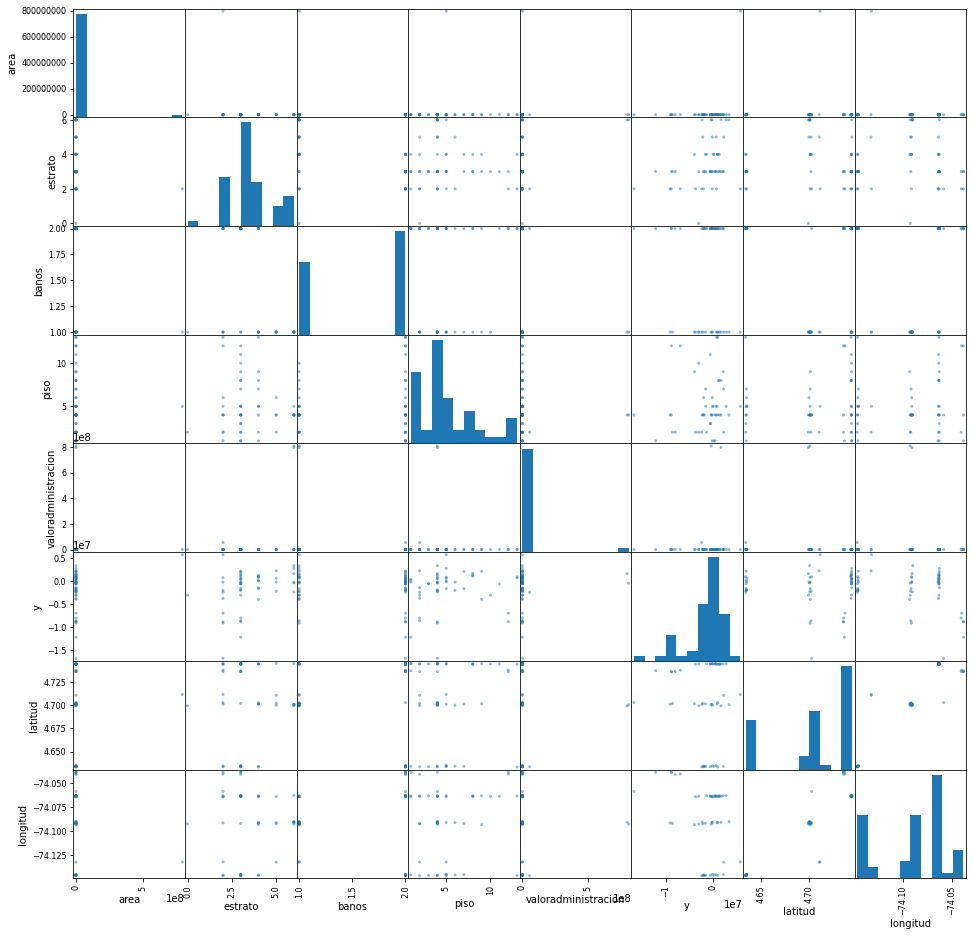

In [15]:
pd.plotting.scatter_matrix(data_test[['area', 'estrato', 'banos', 'piso', 'valoradministracion', 'y',
                                     'latitud', 'longitud']], figsize=(16,16))

## Correlaciones lineales entre las variables

A manera de una descripción breve de los datos así como de lo que se puede incluir en un modelo de regresión se visualizan los tres coeficientes de correlación lineal, aunque se tengan valores bastante bajos en valores absolutos nos podemos dar una idea de que puede influir más en el precio del inmueble. Aun así en el modelo considerado se incluyen todas las variables, más adelante es posible realizar un procedimiento backward para no introducir ruido al modelo.

In [16]:
#Calcular correlación entre variables
df = data_train
correlation_Pearson = df.corr(method='pearson')
i = np.argsort(correlation_Pearson.iloc[0,:]).values
correlation_Pearson = df.iloc[:,i].corr(method='pearson')
correlation_Kendall = df.iloc[:,i].corr(method='kendall')
correlation_Spearman = df.iloc[:,i].corr(method='spearman')

In [17]:
fig = go.Figure()
fig.add_trace(go.Heatmap(z=correlation_Pearson.values,
                         x=np.arange(0,correlation_Pearson.shape[0]),
                         y=correlation_Pearson.columns,hoverongaps = False))
updatemenu = []
buttons = []
buttons.append(dict(method = 'restyle',label = "Correlación de pearson",visible = True, 
                        args = [{'z':[correlation_Pearson.values],
                                 'x':[np.arange(0,correlation_Pearson.shape[0])],
                                 'y':[correlation_Pearson.columns],
                                 'type':'heatmap'}, [0]],))
buttons.append(dict(method = 'restyle',label = "Correlación de kendall",visible = True, 
                        args = [{'z':[correlation_Kendall.values],
                                 'x':[np.arange(0,correlation_Kendall.shape[0])],
                                 'y':[correlation_Kendall.columns],
                                 'type':'heatmap'}, [0]],))
buttons.append(dict(method = 'restyle',label = "Correlación de spearman",visible = True, 
                        args = [{'z':[correlation_Spearman.values],
                                 'x':[np.arange(0,correlation_Spearman.shape[0])],
                                 'y':[correlation_Spearman.columns],
                                 'type':'heatmap'}, [0]],))
updatemenu = []
your_menu = dict()
updatemenu.append(your_menu)
updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['x'] = 0.7
updatemenu[0]['y'] = 1.15
updatemenu[0]['showactive'] = True
fig.update_xaxes(side="top")
fig.update_layout(
    showlegend = False,
    height=500,width = 1000,
    updatemenus = updatemenu,
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,correlation_Pearson.shape[0]),
        ticktext = np.arange(0,correlation_Pearson.shape[0])[::-1]
    ),
    legend_orientation="h"
)
fig.show()

In [18]:
correlations_Tab = pd.DataFrame({'Pearson':correlation_Pearson['y'].values[::-1],
                                'Kendall':correlation_Kendall['y'].values[::-1],
                                'Spearman':correlation_Spearman['y'].values[::-1]})
correlations_Tab.index = correlation_Pearson.index[::-1]
# Tabla de resultados ordenados de acuerdo a la correlación de Pearson
## Marcamos de color verde aquellas correlaciones mayores a 0.4
correlations_Tab.style.applymap(_color_red_or_green)

,Pearson,Kendall,Spearman
id,-0.000208,0.026978,0.040511
tipoinmueble_Casa,-0.003589,0.201705,0.247030
banoservicio,0.000538,-0.007114,-0.008713
tiempodeconstruido_16 a 30 años,0.000987,0.125530,0.153738
tiempodeconstruido_9 a 15 años,0.000939,0.031782,0.038924
valoradministracion,-0.005660,0.024953,0.049435
tiempodeconstruido_1 a 8 años,0.000797,-0.073006,-0.089411
estudio,-0.002182,0.091108,0.111581
habitaciones,-0.002759,0.167676,0.218727
tiempodeconstruido_Más de 30 años,-0.008536,0.098786,0.120985


In [19]:
consolF.describe()

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,estudio,garajes,gimnasio,habitaciones,halldealcobas,parqueaderovisitantes,piscina,piso,porteria,remodelado,terraza,vigilancia,valoradministracion,valorventa,latitud,longitud,V_REF,y,vista_Exterior,vista_Interior,tiempodeconstruido_1 a 8 años,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 0 y 5 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Entre 5 y 10 años,tiempodeconstruido_Menos de 1 año,tiempodeconstruido_Más de 20 años,tiempodeconstruido_Más de 30 años,tiempodeconstruido_Remodelado,tipoinmueble_Apartamento,tipoinmueble_Casa
count,2.419710e+05,2.419710e+05,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.00000,241971.000000,241971.000000,241971.000000,241971.000000,2.419710e+05,2.419710e+05,241971.000000,241971.000000,2.419710e+05,2.419710e+05,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000,241971.000000
mean,6.020402e+05,1.030372e+06,0.358031,0.247608,2.739312,0.050374,0.319596,0.228618,0.530977,4.402875,0.473953,1.705192,0.219733,3.068917,0.841018,0.999996,0.072319,4.28348,0.358299,0.094925,0.175414,0.942241,1.197968e+08,2.891838e+09,4.686867,-74.072267,3.805010e+06,-1.410853e+07,0.842613,0.157387,0.131074,0.161990,0.151770,0.091193,0.197792,0.108244,0.018535,0.079551,0.051626,0.008224,0.762794,0.237206
std,4.054988e+05,2.860020e+07,0.479422,0.431624,1.620511,0.218716,0.466321,0.419944,0.499041,1.318339,0.499322,0.981700,0.414067,1.531446,0.365660,0.002033,0.259015,2.62726,0.479502,0.293111,0.380321,0.233288,3.145019e+08,7.124356e+11,0.048954,0.038226,1.825984e+06,4.395309e+09,0.364166,0.364166,0.337481,0.368443,0.358799,0.287884,0.398335,0.310689,0.134877,0.270597,0.221271,0.090313,0.425371,0.425371
min,6.000000e+00,3.500000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000e+04,5.300000e+07,3.890660,-74.362167,0.000000e+00,-2.160491e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.831865e+05,7.000000e+01,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.00000,0.000000,0.000000,0.000000,1.000000,3.000000e+05,3.100000e+08,4.658168,-74.090164,2.500000e+06,-2.487805e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,5.303300e+05,1.060000e+02,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,2.000000,0.000000,3.000000,1.000000,1.000000,0.000000,4.00000,0.000000,0.000000,0.000000,1.000000,7.000000e+05,5.100000e+08,4.695078,-74.058862,3.500000e+06,-1.300000e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.058235e+05,1.860000e+02,1.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,1.000000,2.000000,0.000000,3.000000,1.000000,1.000000,0.000000,5.00000,1.000000,0.000000,0.000000,1.000000,5.520750e+07,9.000000e+08,4.720226,-74.045438,4.900000e+06,-1.352941e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,6.262945e+06,3.003515e+09,1.000000,1.000000,253.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,10.000000,1.000000,253.000000,1.000000,1.000000,1.000000,30.00000,1.000000,1.000000,1.000000,1.000000,1.800000e+10,3.500000e+14,4.834706,-73.990173,1.590000e+07,1.357537e+

# Modelamiento

Tomamos los datos consolidados y se dividen en dos grupos: Variable respuesta (Y) y variables explicativas (X), los cuales son escaladas mediante el método MinMax. 
$$ X_{MinMax} =  \frac{X-X_{min}}{X_{max}-X_{min}}$$

Esto es necesario debido a la escala de los datos, al dejarlos todos en una misma magnitud permite que el modelo no se vea afectado.

Existen otras normalizaciones pre-programadas en sklearn como:
+ StandardScaler: donde se elimina por la media y se divide entre la desviación estándar.
+ RobustScaler: donde se elimina la mediana y se divide entre el rango intercuartilico (cuantil 25 y 75)
+ QuantileTransform: convierte los datos a través de la función de distirbución acumulada en inversa, lo que se obtendrá serán valores entre 0 y 1, esto se hace a traves del cálculo empirico de la densidad de los datos.
+ PowerTransformer: utiliza la transformación Box-Cox para "normalizar" los datos.
+ normalize: divide los datos sobre su norma vectorial, para obtener vectores unitarios.

In [20]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = consolF[['area','ascensor','balcon','banos', 'banoservicio', 'conjuntocerrado',  'cuartoservicio', 'deposito','estrato', 'estudio', 'garajes' , 'gimnasio' ,'habitaciones', 'halldealcobas' ,'parqueaderovisitantes' , 'piscina' ,'piso','porteria', 'remodelado' ,
                   'terraza', 'vigilancia' ,'valoradministracion', 'vista_Exterior' , 'vista_Interior', 'tiempodeconstruido_1 a 8 años' , 'tiempodeconstruido_16 a 30 años' , 'tiempodeconstruido_9 a 15 años' , 'tiempodeconstruido_Entre 0 y 5 años' , 'tiempodeconstruido_Entre 10 y 20 años' , 'tiempodeconstruido_Entre 5 y 10 años' , 'tiempodeconstruido_Menos de 1 año' , 'tiempodeconstruido_Más de 20 años' ,'tiempodeconstruido_Más de 30 años', 'tiempodeconstruido_Remodelado' , 'tipoinmueble_Apartamento','tipoinmueble_Casa']]
X_train = min_max_scaler.fit_transform(X_train)
X_train.shape


(241971, 36)

In [21]:
y = consolF[['y']]
y  = min_max_scaler.fit_transform( y )
y

array([[0.99999391],
       [0.99999282],
       [0.99999354],
       ...,
       [0.99999402],
       [0.99999432],
       [0.99999472]])



# Deep Neural Network



Se construye un modelo de redes neuronales profundas que permite una mayor complejidad en los datos, para ello se realiza una aleatorización de los datos para poder separarlos en los correspondientes conjuntos de train y test, a pesar de ser dados por el reto pues matemáticamente es importante garantizarlo para un mejor desempeño del modelo.

In [22]:
seed = 611
np.random.seed(seed)
# dividir 70% en train y 30% en test
X_train, X_test, Y_train, Y_test = train_test_split(X_train, y, test_size=0.30, random_state=seed)

In [23]:
print('Train shape:', X_train.shape )
print('Test shape:', X_test.shape )
print('Actual train output:', Y_train.shape )
print('Actual test outpute:', Y_test.shape )

Train shape: (169379, 36)
Test shape: (72592, 36)
Actual train output: (169379, 1)
Actual test outpute: (72592, 1)


Así se crea la red con 4 capas cada una con función de activación relu $f(x) = max(0,x)$ y función de perdida el error cuadrático medio.


In [24]:
def create_model():
    # crear modelo
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # compilar modelo
    model.compile(optimizer ='adam', loss = 'mean_squared_error', 
              metrics =[metrics.mae])
    return model

In [25]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4736      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_________________________________________________________________


In [26]:
import timeit

def entrenamiento_gpu():
  with tf.device('/device:GPU:0'):
    model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=100, batch_size=128)
  
  return None

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')

Epoch 1/100
1324/1324 [==============================] - 7s 3ms/step - loss: 0.0209 - mean_absolute_error: 0.0543 - val_loss: 8.2494e-05 - val_mean_absolute_error: 0.0066
Epoch 2/100
1324/1324 [==============================] - 4s 3ms/step - loss: 7.6388e-05 - mean_absolute_error: 0.0059 - val_loss: 3.2369e-05 - val_mean_absolute_error: 0.0040
Epoch 3/100
1324/1324 [==============================] - 4s 3ms/step - loss: 4.1212e-05 - mean_absolute_error: 0.0040 - val_loss: 4.1902e-05 - val_mean_absolute_error: 0.0055
Epoch 4/100
1324/1324 [==============================] - 4s 3ms/step - loss: 5.9055e-05 - mean_absolute_error: 0.0034 - val_loss: 1.3898e-05 - val_mean_absolute_error: 0.0029
Epoch 5/100
1324/1324 [==============================] - 4s 3ms/step - loss: 3.0496e-05 - mean_absolute_error: 0.0029 - val_loss: 2.7114e-05 - val_mean_absolute_error: 0.0048
Epoch 6/100
1324/1324 [==============================] - 4s 3ms/step - loss: 2.1424e-05 - mean_absolute_error: 0.0027 - val_loss:

In [27]:
print('Tiempo de entrenamiento: ' + str(gpu_time) + ' segundos')
print('Tiempo de entrenamiento: ' ,int(gpu_time)/60, ' minutos')

Tiempo de entrenamiento: 377.85650766 segundos
Tiempo de entrenamiento:  6.283333333333333  minutos


In [28]:
cols = ['area','ascensor','balcon','banos', 'banoservicio', 'conjuntocerrado',  'cuartoservicio', 'deposito','estrato', 'estudio', 'garajes' , 'gimnasio' ,'habitaciones', 'halldealcobas' ,'parqueaderovisitantes' , 'piscina' ,'piso','porteria', 'remodelado' ,
                  'terraza', 'vigilancia' ,'valoradministracion', 'vista_Exterior' , 'vista_Interior', 'tiempodeconstruido_1 a 8 años' , 'tiempodeconstruido_16 a 30 años' , 'tiempodeconstruido_9 a 15 años' , 'tiempodeconstruido_Entre 0 y 5 años' , 'tiempodeconstruido_Entre 10 y 20 años' , 'tiempodeconstruido_Entre 5 y 10 años' , 'tiempodeconstruido_Menos de 1 año' , 'tiempodeconstruido_Más de 20 años' ,'tiempodeconstruido_Más de 30 años', 'tiempodeconstruido_Remodelado' , 'tipoinmueble_Apartamento','tipoinmueble_Casa']
X_test = data_test[cols]
X_test = min_max_scaler.fit_transform( X_test )
prediction = model.predict(X_test)
Y_test  = min_max_scaler.fit_transform( Y_test )
ypred = min_max_scaler.inverse_transform(prediction)

In [33]:
prediccion = pd.DataFrame()
id_col = data_test['id'].values.tolist()
prediccion['id'] = id_col
prediccion['y'] = ypred
prediccion['valormt2_predicted'] = data_test[['V_REF']] - ypred
prediccion[0:5]

,id,y,valormt2_predicted
0,320585,0.999314,5.183999e+06
1,502072,0.999452,4.649990e+05
2,736991,0.999275,2.019999e+06
3,332550,0.999334,5.719999e+06
4,398647,0.999365,3.998972e+06


In [34]:
aux = abs((ypred - data_test[['y']])/data_test[['y']])
aux.describe()

,y
count,51.000000
mean,1.000000
std,0.000003
min,0.999983
25%,0.999999
50%,1.000000
75%,1.000001
max,1.000008


In [36]:
prediccion[['id','valormt2_predicted']].to_csv('/content/gdrive/MyDrive/shp/test_dataV_Kaggle.csv')

# Miscelanea

## Validación cruzada

El método de validación cruzada es usado para seleccionar el modelo que mejor se ajuste a los datos. Consiste en dividir los datos en $K$ conjuntos de entrenamiento y de prueba: los modelos propuestos serán ajustados a cada subconjunto de entrenamento y se evaluará su calidad de ajuste con el subconjunto de prueba, de acuerdo a una medida de error o función  de perdida se determina qué modelo se desempeña mejor.

Nordhausen, K. (2014). An Introduction to Statistical Learning—with Applications in R by Gareth James, Daniela Witten, Trevor Hastie & Robert Tibshirani.

In [ ]:
# Función para validaciones con parámetros: K (cantidad de grupos),train (porcentaje de entreno)
def split(K = 10,train = 0.7):
  Ny = int(data_train.shape[0]*train)
  c = 1
  while c != K:
    idx = np.random.randint(0, data_train.shape[0], Ny, dtype = int)
    idy = np.arange(0, data_train.shape[0],dtype = int)
    idz = np.isin(idy, idx,invert = True)
    idw = idy[idz]
    c = c + 1
    yield idx, idw
for train, test in split(10,0.7):
    print("%s %s" % (train, test))

[ 26646  57805 188628 ... 147531  53047 177420] [     5      8     10 ... 241914 241915 241918]
[111797 101786  25529 ...  83429  62014 157251] [     4      5      6 ... 241915 241917 241919]
[238929  95382  76161 ... 177691  43756 200670] [     1      5      6 ... 241914 241915 241918]
[227011  54449 240153 ... 191861  90232  80648] [     1      8     12 ... 241913 241918 241919]
[194777  33900 173468 ... 225482 144894 220913] [     0      2      4 ... 241915 241916 241918]
[ 92193  77594  69781 ...  84699  47263 211410] [     0      2      5 ... 241915 241918 241919]
[ 46469 100188 155501 ...  89251   9991 135775] [     0      2      3 ... 241917 241918 241919]
[ 26774 129801  37329 ... 119443 237925  28644] [     2      3      4 ... 241914 241915 241918]
[220605 134560 142144 ... 224164 191643 168147] [     2      4      6 ... 241914 241918 241919]


## Calibración hiperparámetros

Los modelos que vamos a considerar son: Regresión lineal con penalización Lasso, regresor del árbol de decisión (Random Forest), máquina de vectores de soporte de regresión (SVR) y una red Neuronal MLP (Multi Layer Perceptron). Cada uno de ellos tiene hiperparámetros que deben ser encontrados, se usará el método de validación cruzada con ese fin.

Para encontrar los hiperparametros óptimos de un modelo, se compara el modelo con diferentes valores de hiperparametros, es decir, se ajustan distintos modelos de la misma clase que serán comparados entre sí, teniendo como criterio la medida de perdida:  error absoluto medio porcentual (MAPE).

El calculo funciona de la siguiente manera: se define una grilla de valores que podrian tomar los hiperparametros  y una particion de los datos en conjuntos entrenamiento-validación (definidos anteriormente en  kfold) que por ejemplo podria ser: $C_{train} = [3\ 4\ 5\ 6\ 7\ 8\ 9]$ y $C_{test} = [10\ 11\ 12\ 13]$ .

A continuación, con esta grilla de valores se ajusta el modelo para cada hiperparametro propuesto (modelos a comparar) con los datos en  $C_{train}$ para luego encontrar las predicciones de la variable respuesta $\hat{Y}_{C_{test}}$ sobre el conjunto test y compararlas con las reales $Y_{C_{test}}$ mediante la medida de error. 

$$\mathrm{MAE}=\frac{1}{|C_{test}|} \sum_{i \in C_{test}}\left|\hat{Y}_{i}-Y_{i}\right|$$

Esta busqueda se realiza mediante la funcion **GridSearchCV** que implementa un método de "ajuste" optimizando mediante la búsqueda de cuadrícula validada cruzada sobre una cuadrícula de parámetros dada.

Para dar un poco de precisión al procedimiento y optimizarlo se realiza una búsqueda en dos faces. En la primera fase buscamos en el intervalo $[a,b]$ con saltos de mayor tamaño donde encontramos un valor optimo $j_1$, luego en la segunda fase se refina la busqueda al rededor del valor encontrado: en $[a,J_1 + mv*j_1]$.

In [ ]:
kfold = split(10,0.7)
score = ['neg_mean_absolute_error']
ScalesFun = {'Function':MinMaxScaler(),'Name':'RobustScaler'}
X = data_train[['area', 'ascensor', 'balcon', 'banos', 'banoservicio',
       'conjuntocerrado', 'cuartoservicio', 'deposito', 'estrato', 'estudio',
       'garajes', 'gimnasio', 'habitaciones', 'halldealcobas',
       'parqueaderovisitantes', 'piscina', 'piso', 'porteria', 'remodelado',
       'terraza', 'vigilancia', 'valoradministracion']]
Y = data_train[['y']]
data_base = {}
data_base['X'] = {}
data_base['X']['scaler'] = ScalesFun['Function']
data_base['X']['scaler'].fit(X)
data_base['X']['rescaled'] = data_base['X']['scaler'].transform(X)
data_base['Y'] = {}
data_base['Y']['scaler'] = ScalesFun['Function']
data_base['Y']['scaler'].fit(Y)
data_base['Y']['rescaled'] = data_base['Y']['scaler'].transform(Y)
# , 'latitud', 'longitud'
 #      ,'vista_Exterior', 'vista_Interior',
 #      'tiempodeconstruido_1 a 8 años', 'tiempodeconstruido_16 a 30 años',
 #      'tiempodeconstruido_9 a 15 años', 'tiempodeconstruido_Entre 0 y 5 años',
 #      'tiempodeconstruido_Entre 10 y 20 años',
 #      'tiempodeconstruido_Entre 5 y 10 años',
 #      'tiempodeconstruido_Menos de 1 año',
 #      'tiempodeconstruido_Más de 20 años',
 #      'tiempodeconstruido_Más de 30 años', 'tiempodeconstruido_Remodelado',
 #      'tipoinmueble_Apartamento', 'tipoinmueble_Casa']]

grids = {}

### Regresión Lasso

Se intenta penalizar la magnitud en valor absoluto de los **p** coeficientes del vector de parámetros, esta penalización se hace sobre la función de costo.
$$Lasso(\pmb{\beta})=\underbrace{\frac{1}{n}\sum_{i=1}^n(Y_i-\pmb{X}_i\pmb{\beta})^2}_{MSE(\beta)}+\color{red}{\lambda||\pmb{\beta}_i||_1}$$
Lo que equivale a minimizar:
$$Lasso(\pmb{\beta})=\underbrace{\frac{1}{n}\sum_{i=1}^n(Y_i-\pmb{X}_i\pmb{\beta})^2}_{MSE(\beta)}+\lambda\sum_{i=1}^p|\pmb{\beta}_i|$$ 

$\lambda$: coeficiente de penalidad. 

Si $\lambda$ es lo suficiente elevado, algunos de los coeficientes pueden llegar a reducirse hasta exactamente 0. Si $\lambda=0$ se obtiene la solución de minimos cuadrados.


*La estimación de $\hat{\pmb{\beta}}_{Lasso}$ no tiene una forma cerrada, para su estimación se requieren métodos númericos*

In [ ]:
model=skl.linear_model.Lasso(max_iter = 10000)
# Creamos una lista con los parámetros y la grilla de valores a probar
params = {'alpha': np.arange(start=1, stop=500, step=10)}
# coeficiente de penalidad (Lambda)
grid = GridSearchCV(model, params, cv = kfold, scoring = score,refit = False)
grid.fit(data_base['X']['rescaled'], data_base['Y']['rescaled'])
par_1 = grid.best_params_['alpha']
#params['alpha'] = np.arange(start = starMV(par_1 - 0.5), stop = par_1 + 0.5, step = 0.001)
#grid = GridSearchCV(model, params, cv=kfold, scoring=score,refit = False)
#grid.fit(data_base['X'], data_base['Y'])
#grids['Lasso' + score] = grid.best_params_
#print (score, grid.best_params_)


### Random Forest

Se puede ver en la [guia del usuario](https://scikit-learn.org/stable/modules/tree.html#tree) lo necesario para este modelo, a grandes rasgos se tiene que:

Dados los vectores de entrenamiento $x_i \in \mathbb{R}^p, i=1,...,n$ y un vector $y \in \mathbb{R}^n$, un árbol de decisión divide el espacio de forma recursiva de manera que las muestras con valor similar en $y_i$ se agrupen.
Los datos en el nodo $m$ representados por $Q$, para cada candidato $\theta=(j,t_m)$ que consiste en una caracteristica $j$ y en un umbral $t_m$ que particiona los datos así:

$$Q_{left}(\theta) = {(x, y) | x_j <= t_m}\\Q_{right}(\theta) = Q \setminus Q_{left}(\theta)$$

La impureza en $m$ se calcula utilizando una función de impureza $H()$

$$G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta))
+ \frac{n_{right}}{N_m} H(Q_{right}(\theta))$$

Que pueden ser 

Error absoluto medio:
$$median(y)_m = \underset{i \in N_m}{\mathrm{median}}(y_i)$$
$$H(X_m) = \frac{1}{N_m} \sum_{i \in N_m} |y_i - median(y)_m|$$

Seleccione los parámetros que minimizan la impureza.

$$\theta^* = \operatorname{argmin}_\theta  G(Q, \theta)$$

Itere para subconjuntos $Q_{left}(\theta^*)$ y $Q_{right}(\theta^*)$ hasta alcanzar la profundidad maxima permitida ($\texttt{max}\_\texttt{depht}$).

In [ ]:
params = {'max_depth': np.round(np.arange(start=1, stop=100, step=10),0)} # La profundidad máxima del árbol
model_DT = DecisionTreeRegressor(splitter= 'best',min_samples_leaf=2,random_state=7)
grid = GridSearchCV(model_DT, params, cv=kfold,  scoring=score,refit = False)
grid.fit(data_base['X']['rescaled'], data_base['Y']['rescaled'])
grids['DecisionTree' + score] = grid.best_params_
print(score, grid.best_params_)

### Support Vector Regression (SVR)

Podemos ir a la [guía de usuario](https://scikit-learn.org/stable/modules/svm.html#svm-regression) para detallar lo necesario del modelo, a grandes rasgos se tiene que:

El problema dual es
$$\min_{\alpha, \alpha^*} \frac{1}{2} (\alpha - \alpha^*)^T Q (\alpha - \alpha^*) + \varepsilon \mathbf{1}^T (\alpha + \alpha^*) - y^T (\alpha - \alpha^*)$$
sujeto a $$\mathbf{1}^T (\alpha - \alpha^*) = 0$$
$$ 0 \leq \alpha_i, \alpha_i^* \leq C, i=1, ..., n$$
 
donde $\mathbf{1}$ es el vector de unos, $Q$ es una matriz semidefinida positiva $n$ por $n$, $Q_{ij}=K(x_i,x_j)=\phi(x_i)^T\phi(x_j)$ es el núcleo. Aquí los vectores de entrenamiento se mapean implícitamente en un espacio dimensional más alto por la función $\phi$.

La predicción es:
$$\sum_{i \in SV}(\alpha_i - \alpha_i^*) K(x_i, x) + b$$

Se puede acceder a estos parámetros a través de los atributos $\texttt{dual}\_\texttt{coef}\_$ que contiene la diferencia $\alpha_i-\alpha_i^*$, $\texttt{support}\_\texttt{vectors}\_$ que contiene los vectores de soporte y $\texttt{intercept}\_$ que contiene el término independiente $b$.

In [ ]:
params_i={}
  iter_max=10000
  param = [{'kernel': ['rbf'], #Los hiperparámetros para este kernel son gamma y C
            'gamma':np.arange(start=0.0001, stop=10, step=2),
            'C':np.arange(start=0.0001, stop=5, step=1),},
          {'kernel': ['poly'], #Los hiperparámetros para este kernerl son gammas, coef0 (intercepto), degree (grados polinomio) y C
            'gamma': np.arange(start=0.0001, stop=10, step=2),
            'coef0': np.arange(start=0.0001, stop=5, step=1), 
            'degree': (2, 3 , 4),
            'C':np.arange(start=0.0001, stop=5, step=1),},
          {'kernel': ['sigmoid'], #Los hiperparámetros para este kernel son coef0 (intercepto), C y gamma
          'coef0':np.arange(start=0.0001, stop=5, step=1),
          'C':np.arange(start=0.0001, stop=5, step=1),
          'gamma':np.arange(start=0.0001, stop=10, step=2)}]
model_svm = SVR(max_iter = iter_max,epsilon = 0.01)
grid_i = GridSearchCV(model_svm, param, cv=kfold, scoring=score)
grid_i.fit(data_base['X'], data_base['Y'])
par_1 =  grid_i.best_params_['gamma']
params_i['gamma'] = np.arange(start=starMV(par_1 - 0.1*10), stop=par_1 + 0.1*10, step=0.1)
par_2 =  grid_i.best_params_['C']
params_i['C'] = np.arange(start=starMV(par_2 - 0.1*10), stop=par_2 + 0.1*10, step=0.1)
model_svm = SVR(max_iter=iter_max,epsilon = 0.01,kernel='rbf')
kernel_i = grid_i.best_params_['kernel']
if kernel_i == 'sigmoid':
  par_3 =  grid_i.best_params_['coef0']
  params_i['coef0'] = np.arange(start=starMV(par_3 - 0.1*10), stop=par_3 + 0.1*10, step=0.1)
  model_svm = SVR(max_iter=iter_max,epsilon = 0.01,kernel='sigmoid')
if kernel_i == 'poly':
  par_3 =  grid_i.best_params_['coef0']
  params_i['coef0'] = np.arange(start=starMV(par_3 - 0.1*10), stop=par_3 + 0.1*10, step=0.1)
  degree_i = grid_i.best_params_['degree']
  model_svm = SVR(max_iter=iter_max,epsilon = 0.01,kernel='poly',degree=degree_i)
grid_i = GridSearchCV(model_svm, params_i, cv=kfold, scoring=score)
grid_i.fit(data_base['X'], data_base['Y'])
grids['SVM' + score] = grid_i.best_params_
grids['SVM' + score]['kernel'] = kernel_i
if kernel_i == 'poly':
  grids['SVM' + score]['degree'] = degree_i
print (score, grids['SVM' + score])

### Multi Layer Perceptron (MLP)

Las redes neuronales artificiales (ANN) son una clase de
modelos utilizados para tareas de clasificación y regresión no
lineal que están motivadas por el cálculo neuronal biológico.

Cada componente $x_i$ de la entrada se multiplica por un peso correspondiente $w_i$, se añade un sesgo y se aplica una función de activación. Los pesos  y sesgos son la información utilizada por la red neuronal para resolver un problema. Estos parámetros deben aprenderse (ajustarse) en el paso de entrenamiento.

Una red **MLP** constituye uno de los modelos más comunes por su condición como aproximador universal de funciones, estas redes utilizan más de una capa 
oculta de neuronas.

De modo que en cada capa j se hará transformaciones lineales del vector de entrada $\vec{x}=(x_1,...,x_N)^T$, se añade un sesgo  y a partir de la función de activación se obtiene un vector de salida $\vec{y}$:
\begin{equation*}
    \vec{y}=\Phi^{(j)} \left(W^{(j)}\vec{x}+\vec{b}^{(j)}\right)
\end{equation*}
 Este $\vec{y}$ será el vector de entrada a la siguiente capa oculta o el resultado en caso de ser la última capa.

In [ ]:
paramMLP = {'solver':['adam'],
          'activation':['logistic','tanh','relu'],
          'hidden_layer_sizes': [(2),(4),(8),(2,4),(4,3),(4,8),(8,2),(4,3,2)],
          'alpha': [0.01,0.001,0.0001,0.00001],
          'learning_rate_init':[0.001,0.01,0.0001,0.1],
          'beta_1':[0.3,0.6,0.9,0.99,0.999],
          'beta_2':[0.3,0.6,0.9,0.99,0.999]}
 
  modelMLP= MLPRegressor(batch_size='auto',verbose=False,shuffle=False,max_iter=1000,random_state=7,validation_fraction=0)
  best_params=[]
  for score in scoring:
    kfold = split(min_n = Nk,n = Ny)
    gridMLP = GridSearchCV(modelMLP, paramMLP, cv=kfold, scoring=score,n_jobs=-1)
    gridMLP.fit(data_base['X']['rescaled'], data_base['Y']['rescaled'])
    best= score, gridMLP.best_params_
    best_params.append(best)
    grids['MLP' + score] = gridMLP.best_params_
    print(score, gridMLP.best_params_)

In [ ]:
#Descomentar para guardar nueva grilla
saved = joblib.dump(grids, os.path.join('/content/gdrive/MyDrive/shp/Grids Habi.joblib'))
#Carga los parámetros elegidos para ahorrar tiempo de ejecución
#grids = joblib.load('Grids Habi.joblib')

## Modelos finales

In [ ]:
 #Función para iniciazar todos los modelos a competir
def inicializarModelos(criterio):
  modelos = []
  grids_i = grids
  if grids_i['SVM' + criterio]['kernel'] == 'poly':
    modelos.append(('SVM', SVR(max_iter=1000,kernel = 'poly',
                               coef0 =  grids_i['SVM' + criterio]['coef0'],
                               gamma = grids_i['SVM' + criterio]['gamma'],
                               C = grids_i['SVM' + criterio]['C'],
                               degree = grids_i['SVM' + criterio]['degree'],
                                 epsilon = 0.001)))
  if grids_i['SVM' + criterio]['kernel'] =='rbf':
    modelos.append(('SVM', SVR(max_iter=1000,kernel = 'rbf',
                               gamma = grids_i['SVM' + criterio]['gamma'],
                               C = grids_i['SVM' + criterio]['C'],
                               epsilon = 0.001)))
  if grids_i['SVM' + criterio]['kernel'] =='sigmoid':
    modelos.append(('SVM', SVR(max_iter = 1000,kernel = 'sigmoid',
                               coef0 = grids_i['SVM' + criterio]['coef0'],
                                 gamma = grids_i['SVM' + criterio]['gamma'],
                                 C = grids_i['SVM' + criterio]['C'],
                                 epsilon = 0.001)))
  modelos.append(('MLP',skl.neural_network.MLPRegressor(hidden_layer_sizes = grids_i['MLP' + criterio]['hidden_layer_sizes'],
                                                          activation = grids_i['MLP' + criterio]['activation'],
                                                          solver = grids_i['MLP' + criterio]['solver'],
                                                          alpha = grids_i['MLP' + criterio]['alpha'],
                                                          beta_1 = grids_i['MLP' + criterio]['beta_1'],
                                                          beta_2 = grids_i['MLP' + criterio]['beta_2'],
                                                          learning_rate_init = grids_i['MLP' + criterio]['learning_rate_init'],
                                                          verbose = False,random_state = 7,
                                                          validation_fraction = 0,shuffle = False,max_iter = 1000)))
  return modelos

In [ ]:
# Iniciamos los modelos
Modelos = {}
Modelos[score] = inicializarModelos(criterio = score)
Resultados = {} # Lista para guardar predicciones y medidas de ajuste
Resultados[score] = {}
results_cv = []
names_cv = []
predictions = {}
for name, modelo in Modelos[score]:
  # Calculamos las medidas de perdida
  kfold = split(min_n = 7,n = 14)
  cv = cross_val_score(modelo,data_base['X'], data_base['Y'],
                        cv = kfold, scoring = score)
  # Ajustamos cada modelo
  modelo.fit(data_base['X'][:],
            data_base['Y'][:])
  # Realizamos las predicciones
  predictions[name] = modelo.predict(data_base['ypred'])
  results_cv.append(cv)
  names_cv.append(np.repeat(name,cv.shape[0]))
Resultados[score]['predictions'] = predictions
Resultados[score]['cv'] = {}
Resultados[score]['cv']['value'] = results_cv
Resultados[score]['cv']['names'] = names_cv

In [ ]:
# Modelos para el promedio
Modelos_promedio = ['Lasso','SVM','MLP','DecisionTree']

In [ ]:
Ny = data_train.shape[0]
predictions = Resultados[score]['predictions']
dfResModels =  pd.DataFrame({'Lasso':predictions['Lasso'],
                          'SVM':predictions['SVM'],
                          'MLP':predictions['MLP'],
                          'DecisionTree':predictions['DecisionTree']})
dfResModels['medias'] = np.nan
dfResModels['medias'][Ny:]=dfResModels[Modelos_promedio][Ny:].mean(axis=1)
dfResModels['Real']=data_base['Y'].values
dfResModels.index = data_base['X'].index
Resultados[score]['dataframe'] = dfResModels

In [ ]:
sc = score
df = pd.DataFrame({'values': np.reshape(np.array(Resultados[sc]['cv']['value']),-1),
                   'model': np.reshape(np.array(Resultados[sc]['cv']['names']),-1)})
fig = go.Figure()
fig.add_trace(go.Box(y = df['values'],x = df['model'],boxpoints = 'all',boxmean=True))
fig.update_layout(boxmode='group',template = "plotly_white",title_text="Cv " + sc)
fig.show()

In [ ]:
df.groupby('model').mean().sort_values('values',ascending=False).T

In [ ]:
models=Resultados[scoring[0]]['dataframe'].columns
MSE=[]
for i in models[:-2]:
  aux=mean_squared_error(data_base['Y']['rescaled'],Resultados[scoring[0]]['predictions'][i][:Ny])
  MSE.append(aux)
b=pd.DataFrame({'MSE':MSE},index=models[:-2]) 
b.sort_values('MSE',ascending=True).T

## Otros enfoques

In [ ]:
X_train = data_train.drop(['y'], 1)
X_test = data_test.drop(['y'], 1)

y_train = data_train['y']
y_test = data_test['y']

In [ ]:
# Linear model por probar
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train) # max_iter es para la advertencia de convergencia

print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))

lasso regression linear model intercept: -5772670316.797512
lasso regression linear model coeff:
[-1.80544764e+09 -1.36216367e+08 -4.37492450e+08 -9.20477095e+10
  3.53969449e+08 -1.65653449e+07 -1.37899925e+09 -6.99724881e+08
  7.04568160e+09 -4.66208874e+08  5.82913884e+07  4.67347807e+08
  2.95161834e+10 -9.89081151e+07  1.54766373e+09  7.65478503e+07
  1.96501663e+09  9.98838618e+07  1.76402570e+08  2.13156242e+08
 -2.86994899e+05 -5.99430877e+09 -9.99999516e+14  7.18781380e+09
 -4.64796068e+09 -5.51704651e+08  6.88312916e+07 -0.00000000e+00
  1.98712919e+08  1.53418380e+08  4.07593845e+07 -1.04490805e+08
 -9.96251284e+07 -1.05471918e+08  3.43003386e+08  8.94320991e+07
  2.07183920e+08 -4.02094551e+08 -1.64012071e+09  7.59600836e-06]
Non-zero features: 39
R-squared score (training): 1.000
R-squared score (test): -162.736



In [ ]:
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

val = {'alpha': [0.2, 0.5, 1, 2, 3, 5, 10, 15, 20, 15, 30, 45, 50]}

linlasso = Lasso( max_iter = 10000)

grid= GridSearchCV(linlasso, param_grid = val, scoring= 'r2', n_jobs=4)
grid.fit(X_train_scaled, y_train)
print('mejor parámetro (max. accuracy): ', grid.best_params_)
y_pred= grid.predict(X_test_scaled)

# Test data
print('error cuadrado medio : ' + str(mean_squared_error(y_test,y_pred)))
print('R2: ' + str(r2_score(y_test,y_pred)))


mejor parámetro (max. accuracy):  {'alpha': 50}
error cuadrado medio : 4.0042142984897413e+18
R2: -162.73361394990593


In [ ]:
from sklearn.svm import SVR


svr = SVR(kernel='rbf')
valores = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_svr= GridSearchCV(svr, param_grid = valores, verbose=1, n_jobs=-1)
grid_svr.fit(X_train, y_train)
y_pred= grid_svr.predict(X_test)

print('mejor parámetros (max. accuracy): ', grid_svr.best_params_)

# Test data
print('error cuadrado medio : ' + str(mean_squared_error(y_test,y_pred)))
print('R2: ' + str(r2_score(y_test,y_pred)))


In [ ]:
from sklearn.ensemble import RandomForestRegressor
 
 # Puede ser con max_edpth o n_estimator
valores  = {'n_estimators': [100, 500, 1000, 5000, 10000]}
rf = RandomForestRegressor( random_state = 0)

grid_rf= GridSearchCV(rf, param_grid = valores)
grid_rf.fit(X_train, y_train)

y_pred= grid_rf.predict(X_test)

print('mejor parámetros (max. accuracy): ', grid_rf.best_params_)

# Test data
print('error cuadrado medio : ' + str(mean_squared_error(y_test,y_pred)))
print('R2: ' + str(r2_score(y_test,y_pred)))